# Rumour Detection Analysis

This notebook performs rumor detection analysis with the following steps:

1. Data Loading and Initial Exploration
2. Data Cleaning
3. Exploratory Data Analysis (EDA)
4. Model Development with Custom Labels
   - Not a rumor: 0-0.35
   - Need more information: 0.35-0.65
   - Rumor: 0.65-1


In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samiul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samiul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samiul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
# Load the dataset
df = pd.read_csv('../Rumour dataset.csv')

# Display basic information about the dataset
print("Dataset Info:")
print("-" * 50)
print(df.info())
print("\nSample of the dataset:")
print("-" * 50)
display(df.head())
print("\nMissing values:")
print("-" * 50)
print(df.isnull().sum())

Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62445 entries, 0 to 62444
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text         62445 non-null  object 
 1   is_rumor     62443 non-null  float64
 2   user.handle  62443 non-null  object 
 3   topic        49668 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.9+ MB
None

Sample of the dataset:
--------------------------------------------------


,text,is_rumor,user.handle,topic
0,Charlie Hebdo became well known for publishing...,0.0,BBCDanielS,charliehebdo
1,"Now 10 dead in a shooting there today RT ""@BBC...",0.0,robbylevy,charliehebdo
2,@BBCDanielS @BBCWorld I'm guessing this is bei...,0.0,ModerateInAll,charliehebdo
3,@BBCDanielS @BBCWorld why would you mention th...,0.0,GabTarquini,charliehebdo
4,@BBCDanielS @BBCWorld perps identified?,0.0,freethought41,charliehebdo



Missing values:
--------------------------------------------------
text               0
is_rumor           2
user.handle        2
topic          12777
dtype: int64


## Data Cleaning

We'll perform the following cleaning steps:

1. Handle missing values
2. Remove duplicates
3. Text cleaning (remove special characters, URLs, etc.)
4. Convert text to lowercase
5. Remove stopwords
6. Lemmatization


In [20]:
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        
        # Remove special characters and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        
        # Tokenization
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    return ''

# Create a copy of the dataframe
df_cleaned = df.copy()

# Handle missing values
df_cleaned = df_cleaned.dropna()

# Remove duplicates
df_cleaned = df_cleaned.drop_duplicates()

# Clean text
df_cleaned['cleaned_text'] = df_cleaned['text'].apply(clean_text)

print("Shape before cleaning:", df.shape)
print("Shape after cleaning:", df_cleaned.shape)

Shape before cleaning: (62445, 4)
Shape after cleaning: (48871, 5)


## Exploratory Data Analysis (EDA)


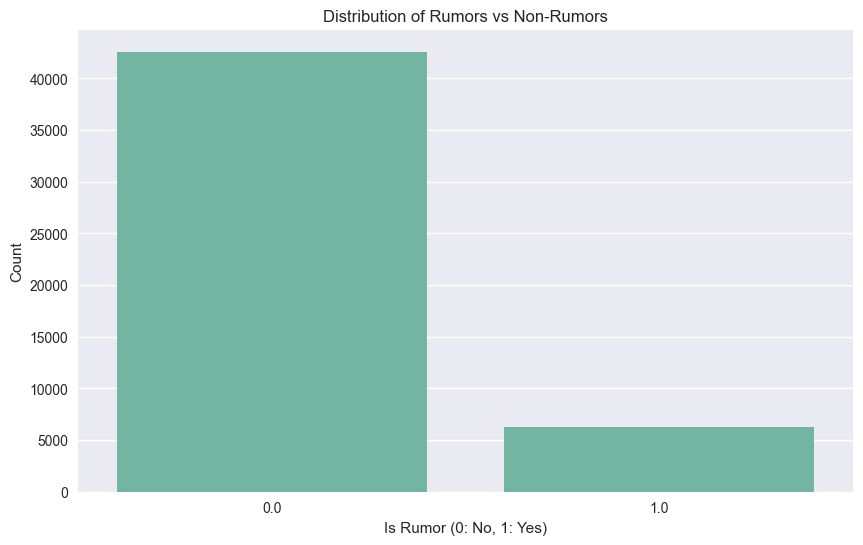

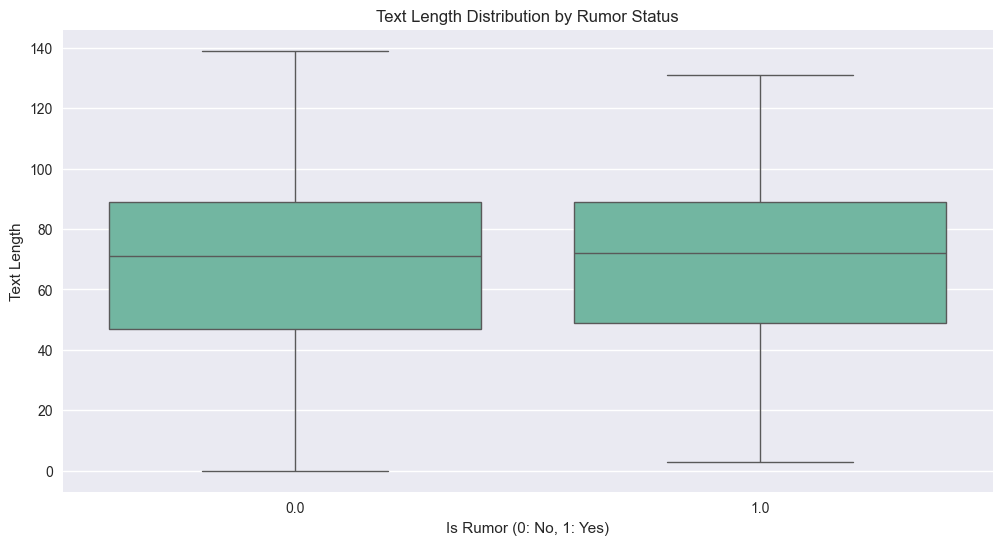

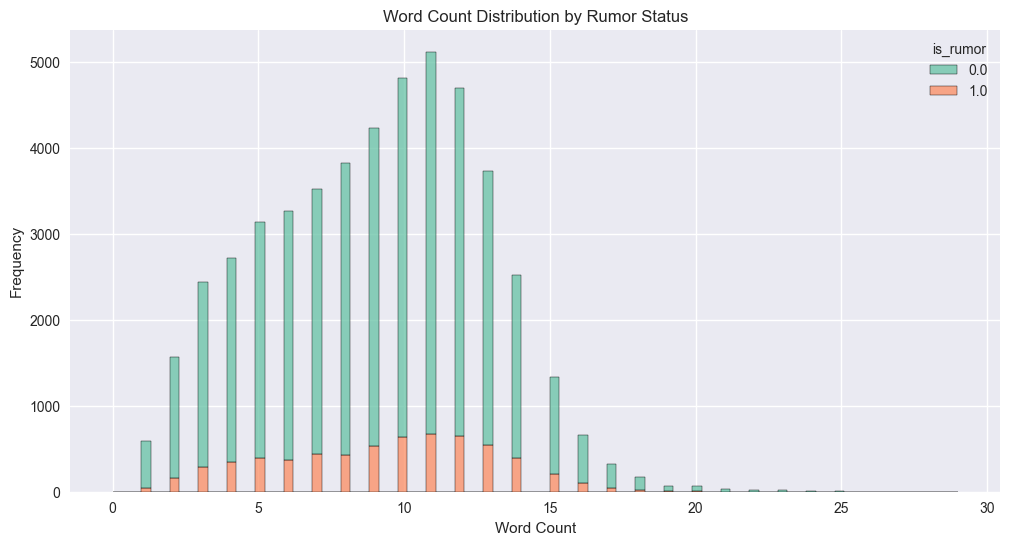

In [21]:
# 1. Distribution of Rumor vs Non-Rumor
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='is_rumor')
plt.title('Distribution of Rumors vs Non-Rumors')
plt.xlabel('Is Rumor (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# 2. Text Length Analysis
df_cleaned['text_length'] = df_cleaned['cleaned_text'].str.len()
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned, x='is_rumor', y='text_length')
plt.title('Text Length Distribution by Rumor Status')
plt.xlabel('Is Rumor (0: No, 1: Yes)')
plt.ylabel('Text Length')
plt.show()

# 3. Word Count Analysis
df_cleaned['word_count'] = df_cleaned['cleaned_text'].str.split().str.len()
plt.figure(figsize=(12, 6))
sns.histplot(data=df_cleaned, x='word_count', hue='is_rumor', multiple="stack")
plt.title('Word Count Distribution by Rumor Status')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Model Development

We'll use TF-IDF vectorization and a machine learning model to predict rumor probability, then classify according to the specified thresholds:

- 0-0.35: Not a rumor
- 0.35-0.65: Need more information
- 0.65-1: Rumor


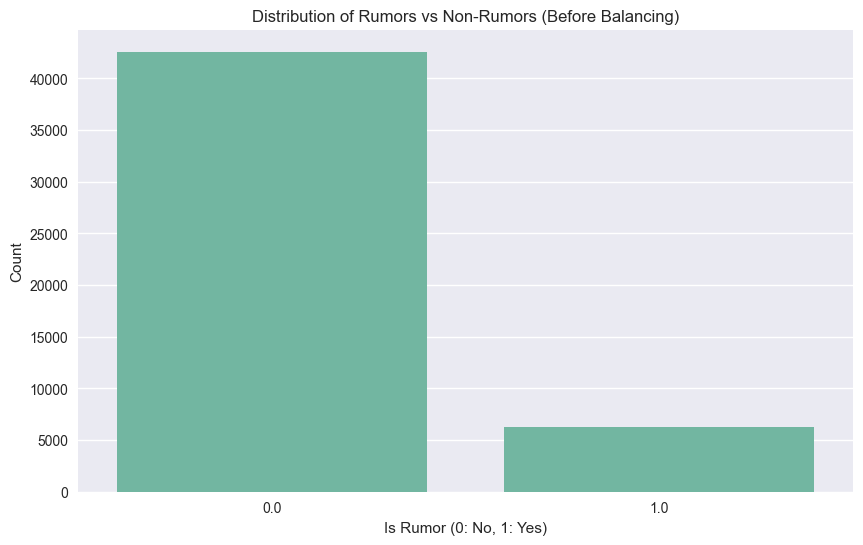

Class distribution before balancing:
is_rumor
0.0    42590
1.0     6281
Name: count, dtype: int64
Class ratio (rumor/non-rumor): 0.1475

Applying SMOTE to balance the classes...

Applying SMOTE to balance the classes...
Class distribution after SMOTE:
is_rumor
0.0    34093
1.0    34093
Name: count, dtype: int64
New class ratio (rumor/non-rumor): 1.0
Sample Predictions:
Class distribution after SMOTE:
is_rumor
0.0    34093
1.0    34093
Name: count, dtype: int64
New class ratio (rumor/non-rumor): 1.0
Sample Predictions:


,Text,True_Label,Probability,Prediction
0,spants jlpauk tom_sveb rui_xu p much,1.0,0.991016,Rumor
1,green_footballs foxnow thought picture missour...,0.0,0.069673,Not a rumor
2,politicspeach murdered damn quick trial screw ...,0.0,0.310937,Not a rumor
3,nearly k black murdered last yralmost black ti...,1.0,0.332259,Not a rumor
4,tyamend mashable nycjim information released c...,1.0,0.873475,Rumor


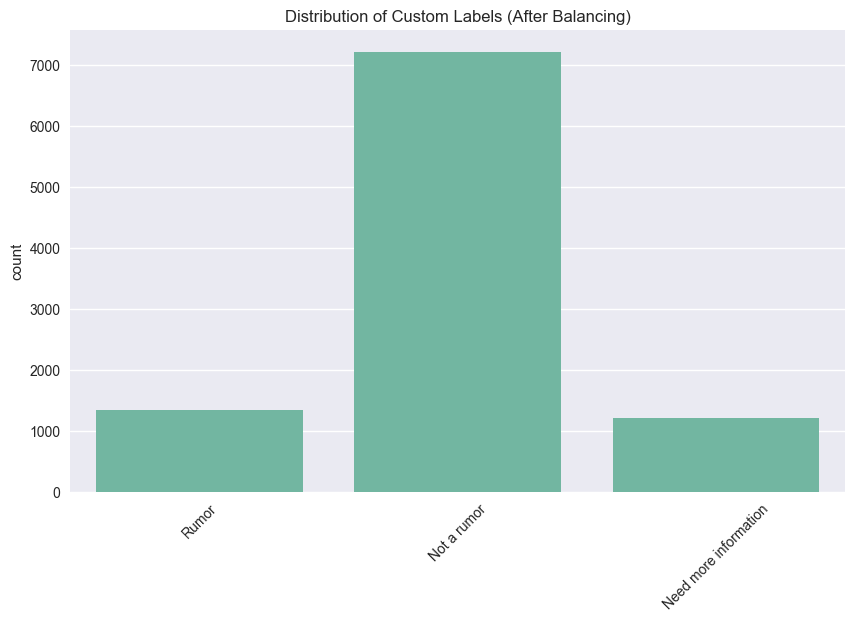

In [22]:
# Prepare the data
X = df_cleaned['cleaned_text']
y = df_cleaned['is_rumor']

# Display class distribution before balancing
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='is_rumor')
plt.title('Distribution of Rumors vs Non-Rumors (Before Balancing)')
plt.xlabel('Is Rumor (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

print("Class distribution before balancing:")
print(y.value_counts())
print("Class ratio (rumor/non-rumor):", round(y.value_counts()[1]/y.value_counts()[0], 4))

# Import required libraries for sampling
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.linear_model import LogisticRegression
# Split the data first to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Apply SMOTE for oversampling the minority class (rumors)
print("\nApplying SMOTE to balance the classes...")
smote = SMOTE(random_state=42)
X_train_tfidf_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

# Display class distribution after balancing
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())
print("New class ratio (rumor/non-rumor):", round(pd.Series(y_train_balanced).value_counts()[1]/pd.Series(y_train_balanced).value_counts()[0], 4))

# Train the model with balanced data
model = LogisticRegression(random_state=42)
model.fit(X_train_tfidf_balanced, y_train_balanced)

# Get probability predictions
y_prob = model.predict_proba(X_test_tfidf)[:, 1]

# Custom labeling function
def get_custom_label(prob):
    if prob < 0.35:
        return 'Not a rumor'
    elif prob < 0.65:
        return 'Need more information'
    else:
        return 'Rumor'

# Apply custom labels
custom_labels = [get_custom_label(prob) for prob in y_prob]

# Create results DataFrame
results_df = pd.DataFrame({
    'Text': X_test.values,
    'True_Label': y_test.values,
    'Probability': y_prob,
    'Prediction': custom_labels
})

# Display results
print("Sample Predictions:")
display(results_df.head())

# Distribution of custom labels
plt.figure(figsize=(10, 6))
sns.countplot(x=custom_labels)
plt.title('Distribution of Custom Labels (After Balancing)')
plt.xticks(rotation=45)
plt.show()

c:\Users\samiul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.8711 - loss: 0.2775 - val_accuracy: 0.9819 - val_loss: 0.0724
Epoch 2/20
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.8711 - loss: 0.2775 - val_accuracy: 0.9819 - val_loss: 0.0724
Epoch 2/20
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9784 - loss: 0.0631 - val_accuracy: 0.9930 - val_loss: 0.0274
Epoch 3/20
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9784 - loss: 0.0631 - val_accuracy: 0.9930 - val_loss: 0.0274
Epoch 3/20
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9888 - loss: 0.0299 - val_accuracy: 0.9968 - val_loss: 0.0110
Epoch 4/20
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9888 - loss: 0.0299 - val_accuracy: 0.9968 - val_loss: 0.0110
Epoch 4/20
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.9917 - loss: 0.0203 - val_accuracy: 0.9967 - val_loss: 0.0347
Epoch 5/20
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.9917 -

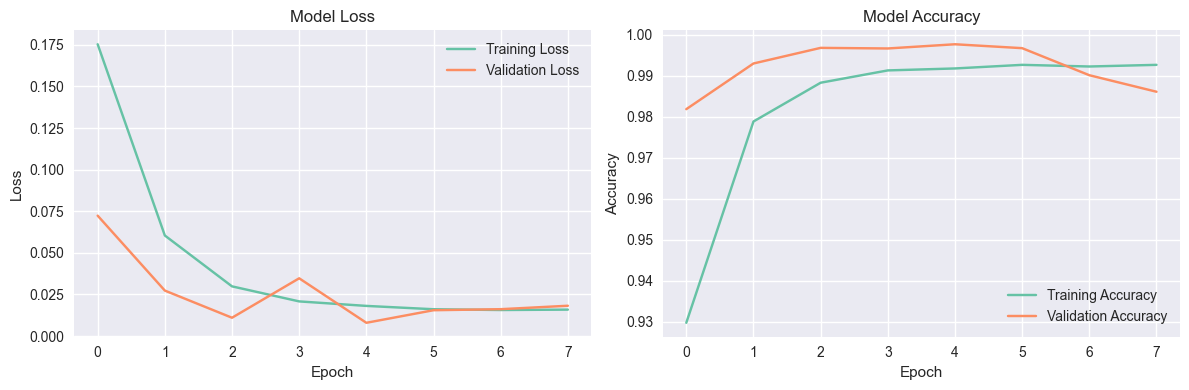

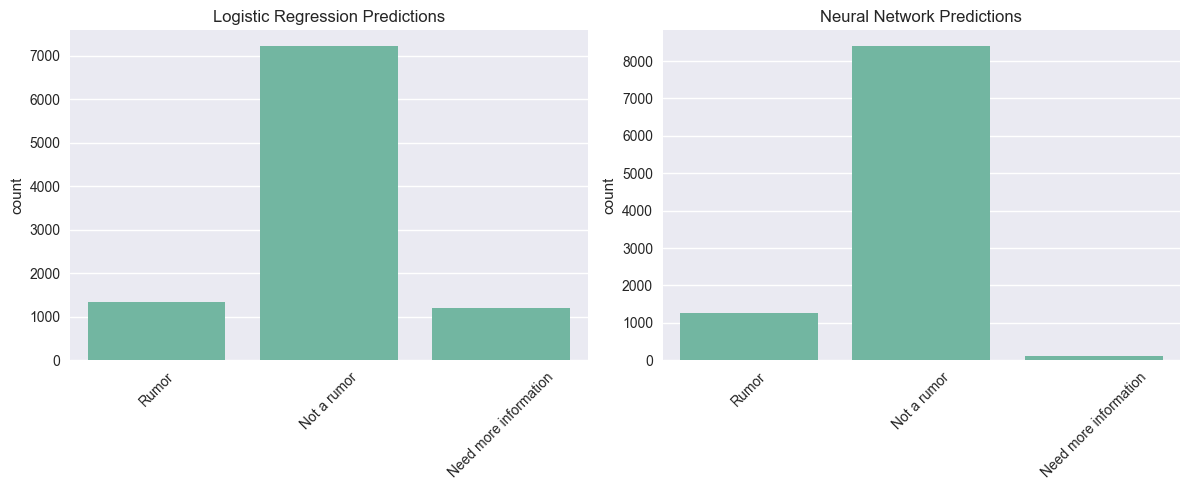


Logistic Regression Performance:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      8497
         1.0       0.73      0.77      0.75      1278

    accuracy                           0.93      9775
   macro avg       0.85      0.86      0.86      9775
weighted avg       0.93      0.93      0.93      9775


Neural Network Performance:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96      8497
         1.0       0.77      0.76      0.76      1278

    accuracy                           0.94      9775
   macro avg       0.87      0.86      0.86      9775
weighted avg       0.94      0.94      0.94      9775



In [23]:
from sklearn.metrics import classification_report

# Convert sparse matrix to dense array for neural network
X_train_tfidf_balanced_dense = X_train_tfidf_balanced.toarray()
X_test_dense = X_test_tfidf.toarray()

# Define the neural network model
def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    return model

# Create and compile the model
nn_model = create_model(X_train_tfidf_balanced_dense.shape[1])
nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model on balanced data
history = nn_model.fit(
    X_train_tfidf_balanced_dense,
    y_train_balanced,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Get predictions
y_prob_nn = nn_model.predict(X_test_dense)

# Apply custom labels for neural network predictions
custom_labels_nn = [get_custom_label(prob[0]) for prob in y_prob_nn]

# Create results DataFrame for neural network
results_df_nn = pd.DataFrame({
    'Text': X_test.values,
    'True_Label': y_test.values,
    'Probability': y_prob_nn.flatten(),
    'Prediction': custom_labels_nn
})

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Compare distributions of predictions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=custom_labels)
plt.title('Logistic Regression Predictions')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x=custom_labels_nn)
plt.title('Neural Network Predictions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print classification metrics for both models
print("\nLogistic Regression Performance:")
print("-" * 50)
print(classification_report(y_test, [1 if label == 'Rumor' else 0 for label in custom_labels]))

print("\nNeural Network Performance:")
print("-" * 50)
print(classification_report(y_test, [1 if label == 'Rumor' else 0 for label in custom_labels_nn]))


In [24]:

# Enhanced model incorporating temporal and propagation features
def create_enhanced_model(input_dim, user_feature_dim=6):
    # Main content branch
    content_input = tf.keras.Input(shape=(input_dim,), name='content_input')
    x1 = Dense(256, activation='relu')(content_input)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)
    
    # User features branch (followers, friends, ratio, history, registration, verified)
    user_input = tf.keras.Input(shape=(user_feature_dim,), name='user_input')
    x2 = Dense(32, activation='relu')(user_input)
    x2 = Dense(16, activation='relu')(x2)
    
    # Combine both branches
    combined = tf.keras.layers.concatenate([x1, x2])
    
    # Additional layers for combined features
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.1)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[content_input, user_input], name='enhanced_rumor_detector')
    return model

# Function to extract user features
def extract_user_features(df):
    # Normalize user features
    scaler = StandardScaler()
    user_features = np.zeros((len(df), 6))
    
    if 'user_followers' in df.columns:
        user_features[:, 0] = scaler.fit_transform(df['user_followers'].values.reshape(-1, 1)).ravel()
    if 'user_friends' in df.columns:
        user_features[:, 1] = scaler.fit_transform(df['user_friends'].values.reshape(-1, 1)).ravel()
    if 'user_followers' in df.columns and 'user_friends' in df.columns:
        ratio = df['user_followers'] / (df['user_friends'] + 1)  # Add 1 to avoid division by zero
        user_features[:, 2] = scaler.fit_transform(ratio.values.reshape(-1, 1)).ravel()
    if 'user_statuses' in df.columns:
        user_features[:, 3] = scaler.fit_transform(df['user_statuses'].values.reshape(-1, 1)).ravel()
    if 'account_age' in df.columns:
        user_features[:, 4] = scaler.fit_transform(df['account_age'].values.reshape(-1, 1)).ravel()
    if 'verified' in df.columns:
        user_features[:, 5] = df['verified'].astype(int)
    
    return user_features

# If user features are available in the dataset
if any(col in df_cleaned.columns for col in ['user_followers', 'user_friends', 'user_statuses', 'verified']):
    # Extract user features
    user_features = extract_user_features(df_cleaned)
    
    # Split user features along with content features
    _, user_features_test = train_test_split(user_features, test_size=0.2, random_state=42)
    
    # Create and compile enhanced model
    enhanced_model = create_enhanced_model(X_train_tfidf_balanced_dense.shape[1])
    enhanced_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train enhanced model
    enhanced_history = enhanced_model.fit(
        [X_train_tfidf_balanced_dense, user_features[:-len(user_features_test)]],
        y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Get predictions from enhanced model
    y_prob_enhanced = enhanced_model.predict([X_test_dense, user_features_test])
    custom_labels_enhanced = [get_custom_label(prob[0]) for prob in y_prob_enhanced]
    
    # Plot enhanced model performance
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(enhanced_history.history['loss'], label='Training Loss')
    plt.plot(enhanced_history.history['val_loss'], label='Validation Loss')
    plt.title('Enhanced Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(enhanced_history.history['accuracy'], label='Training Accuracy')
    plt.plot(enhanced_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Enhanced Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print enhanced model performance
    print("\nEnhanced Neural Network Performance:")
    print("-" * 50)
    print(classification_report(y_test, [1 if label == 'Rumor' else 0 for label in custom_labels_enhanced]))
    
    # Compare model predictions
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.countplot(x=custom_labels)
    plt.title('Logistic Regression')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 2)
    sns.countplot(x=custom_labels_nn)
    plt.title('Basic Neural Network')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 3)
    sns.countplot(x=custom_labels_enhanced)
    plt.title('Enhanced Neural Network')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Sequence data shape before SMOTE: (39096, 100)
Sequence data shape after SMOTE: (68186, 100)
Class distribution after SMOTE for sequence data:
is_rumor
0.0    34093
1.0    34093
Name: count, dtype: int64

Bi-LSTM Model Summary:


c:\Users\samiul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_text          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  3,768,500 │ input_text[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 100)       │          0 │ input_text[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │     84,480 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     98,816 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,960,117 (15.11 MB)

 Trainable params: 3,960,117 (15.11 MB)

 Non-trainable params: 0 (0.00 B)


Training Bi-LSTM model on balanced data...
Epoch 1/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 167s 96ms/step - accuracy: 0.7590 - loss: 0.4899 - val_accuracy: 0.7896 - val_loss: 0.4726
Epoch 2/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 167s 96ms/step - accuracy: 0.7590 - loss: 0.4899 - val_accuracy: 0.7896 - val_loss: 0.4726
Epoch 2/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 168s 98ms/step - accuracy: 0.9194 - loss: 0.2100 - val_accuracy: 0.8258 - val_loss: 0.4197
Epoch 3/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 168s 98ms/step - accuracy: 0.9194 - loss: 0.2100 - val_accuracy: 0.8258 - val_loss: 0.4197
Epoch 3/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 172s 101ms/step - accuracy: 0.9526 - loss: 0.1229 - val_accuracy: 0.8519 - val_loss: 0.4235
Epoch 4/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 172s 101ms/step - accuracy: 0.9526 - loss: 0.1229 - val_accuracy: 0.8519 - val_loss: 0.4235
Epoch 4/10
1705/1705 ━━━━━━━━━━━━━━━━━━━━ 170s 100ms/step - accuracy: 0.9710 - loss: 0.0769 - val_accuracy: 0.8050 - val_loss: 0.7856
Epoch 5/10
1705/1705 ━

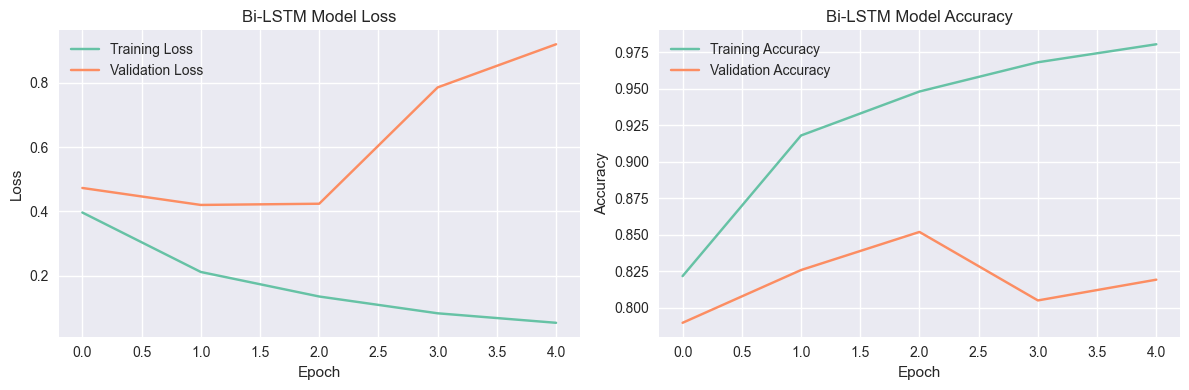


Bi-LSTM Model Performance:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      8497
         1.0       0.70      0.79      0.74      1278

    accuracy                           0.93      9775
   macro avg       0.83      0.87      0.85      9775
weighted avg       0.93      0.93      0.93      9775



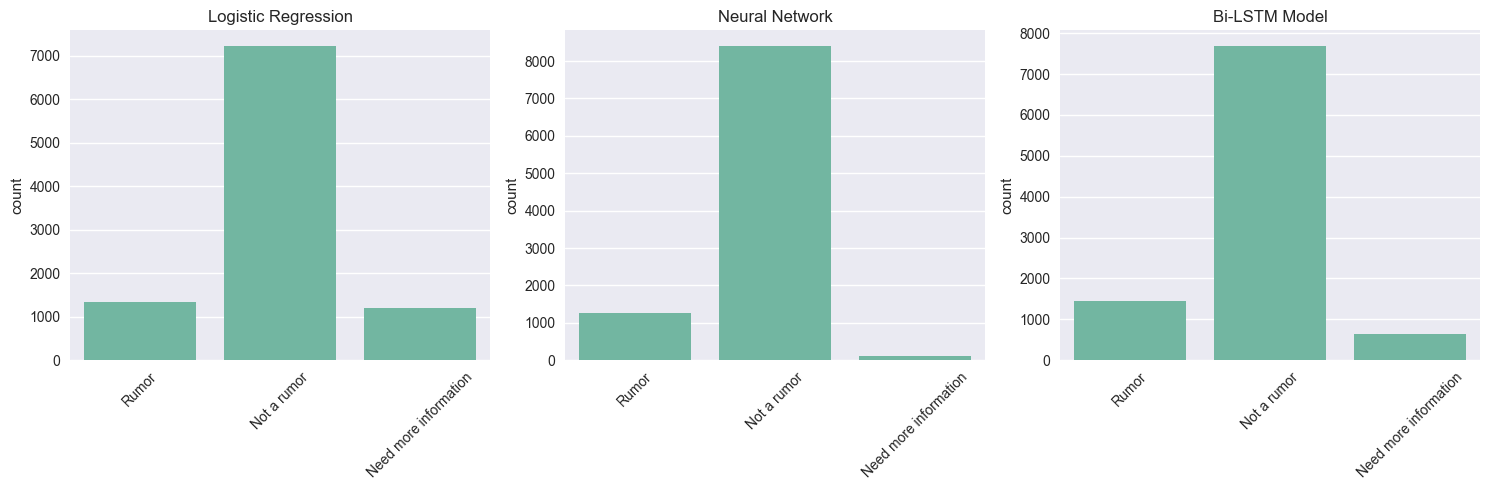

In [25]:

# Add Bi-LSTM model implementation based on research paper s12652-022-03900-2.pdf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Concatenate, Input
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical

# Function to preprocess text for LSTM model
def preprocess_for_lstm(texts, max_seq_length=50, max_words=5000):
    """
    Preprocess text data for LSTM model:
    - Tokenize the text
    - Convert to sequences of integers
    - Pad sequences to the same length
    """
    from tensorflow.keras.preprocessing.text import Tokenizer
    
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return padded_sequences, tokenizer

# Preprocess the text data for LSTM model using the same training data
max_seq_length = 100
max_words = 10000
X_train_seq, tokenizer = preprocess_for_lstm(X_train, max_seq_length, max_words)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_seq_length, padding='post')

# Apply SMOTE to balance the sequential data
# We need to convert sequential data to array form for SMOTE
X_train_seq_reshaped = X_train_seq.reshape(X_train_seq.shape[0], -1)
smote_seq = SMOTE(random_state=42)
X_train_seq_balanced, y_train_seq_balanced = smote_seq.fit_resample(X_train_seq_reshaped, y_train)
# Reshape back to sequential form
X_train_seq_balanced = X_train_seq_balanced.reshape(X_train_seq_balanced.shape[0], max_seq_length)

print(f"Sequence data shape before SMOTE: {X_train_seq.shape}")
print(f"Sequence data shape after SMOTE: {X_train_seq_balanced.shape}")
print(f"Class distribution after SMOTE for sequence data:")
print(pd.Series(y_train_seq_balanced).value_counts())

# Create a Bi-LSTM model architecture based on the research paper
def create_bilstm_model(vocab_size, embedding_dim=100, lstm_units=64, max_seq_length=100):
    """
    Create a Bidirectional LSTM model for rumor detection as specified in the paper
    """
    # Input layer
    input_text = Input(shape=(max_seq_length,), name='input_text')
    
    # Embedding layer
    embedding = Embedding(input_dim=vocab_size+1, 
                         output_dim=embedding_dim, 
                         input_length=max_seq_length, 
                         mask_zero=True)(input_text)
    
    # Bidirectional LSTM layers
    bilstm_1 = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
    bilstm_2 = Bidirectional(LSTM(lstm_units, return_sequences=False))(bilstm_1)
    
    # Dense layers for classification
    dense1 = Dense(64, activation='relu')(bilstm_2)
    dropout = Dropout(0.3)(dense1)
    output = Dense(1, activation='sigmoid')(dropout)
    
    # Define the model
    model = Model(inputs=input_text, outputs=output)
    
    return model

# Create and compile the Bi-LSTM model
vocab_size = len(tokenizer.word_index)
bilstm_model = create_bilstm_model(vocab_size, embedding_dim=100, lstm_units=64, max_seq_length=max_seq_length)

# Compile the model
bilstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("\nBi-LSTM Model Summary:")
bilstm_model.summary()

# Add early stopping
early_stopping_bilstm = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the Bi-LSTM model on balanced data
print("\nTraining Bi-LSTM model on balanced data...")
bilstm_history = bilstm_model.fit(
    X_train_seq_balanced,
    y_train_seq_balanced,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_bilstm],
    verbose=1
)

# Get predictions from Bi-LSTM model
y_prob_bilstm = bilstm_model.predict(X_test_seq)
custom_labels_bilstm = [get_custom_label(prob[0]) for prob in y_prob_bilstm]

# Create results DataFrame for Bi-LSTM model
results_df_bilstm = pd.DataFrame({
    'Text': X_test.values,
    'True_Label': y_test.values,
    'Probability': y_prob_bilstm.flatten(),
    'Prediction': custom_labels_bilstm
})

# Plot Bi-LSTM training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(bilstm_history.history['loss'], label='Training Loss')
plt.plot(bilstm_history.history['val_loss'], label='Validation Loss')
plt.title('Bi-LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bilstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(bilstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Bi-LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Print classification metrics for Bi-LSTM model
print("\nBi-LSTM Model Performance:")
print("-" * 50)
print(classification_report(y_test, [1 if label == 'Rumor' else 0 for label in custom_labels_bilstm]))

# Compare all models
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=custom_labels)
plt.title('Logistic Regression')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.countplot(x=custom_labels_nn)
plt.title('Neural Network')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.countplot(x=custom_labels_bilstm)
plt.title('Bi-LSTM Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Creating optimized RNN model...
Optimized RNN Model Summary:


c:\Users\samiul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training optimized RNN model on balanced data...
Epoch 1/10


c:\Users\samiul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


853/853 ━━━━━━━━━━━━━━━━━━━━ 156s 178ms/step - accuracy: 0.7176 - auc_1: 0.7513 - loss: 0.6351 - precision_1: 0.6760 - recall_1: 0.4680 - val_accuracy: 0.7937 - val_auc_1: 0.0000e+00 - val_loss: 0.4918 - val_precision_1: 1.0000 - val_recall_1: 0.7937 - learning_rate: 0.0010
Epoch 2/10
853/853 ━━━━━━━━━━━━━━━━━━━━ 156s 178ms/step - accuracy: 0.7176 - auc_1: 0.7513 - loss: 0.6351 - precision_1: 0.6760 - recall_1: 0.4680 - val_accuracy: 0.7937 - val_auc_1: 0.0000e+00 - val_loss: 0.4918 - val_precision_1: 1.0000 - val_recall_1: 0.7937 - learning_rate: 0.0010
Epoch 2/10
853/853 ━━━━━━━━━━━━━━━━━━━━ 113s 133ms/step - accuracy: 0.8931 - auc_1: 0.9515 - loss: 0.2997 - precision_1: 0.8733 - recall_1: 0.8361 - val_accuracy: 0.7226 - val_auc_1: 0.0000e+00 - val_loss: 0.6361 - val_precision_1: 1.0000 - val_recall_1: 0.7226 - learning_rate: 0.0010
Epoch 3/10
853/853 ━━━━━━━━━━━━━━━━━━━━ 113s 133ms/step - accuracy: 0.8931 - auc_1: 0.9515 - loss: 0.2997 - precision_1: 0.8733 - recall_1: 0.8361 - val_

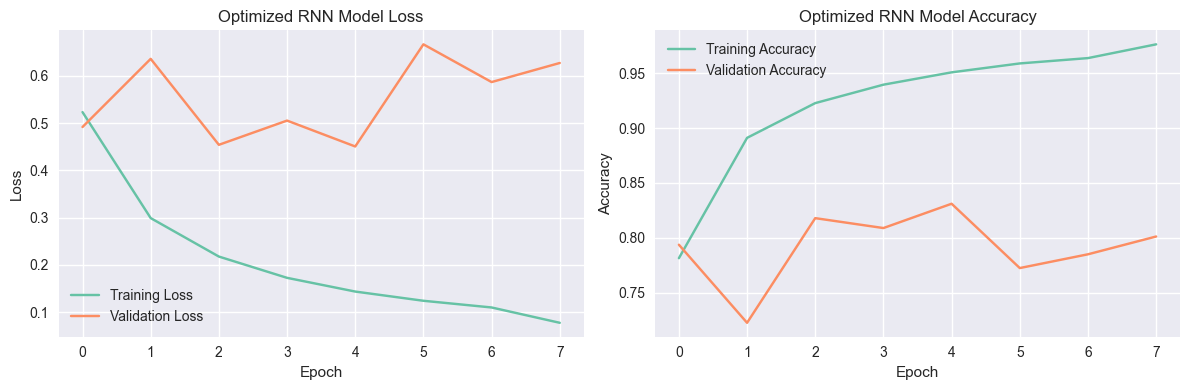


Optimized RNN Model Performance:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      8497
         1.0       0.63      0.81      0.71      1278

    accuracy                           0.91      9775
   macro avg       0.80      0.87      0.83      9775
weighted avg       0.93      0.91      0.92      9775



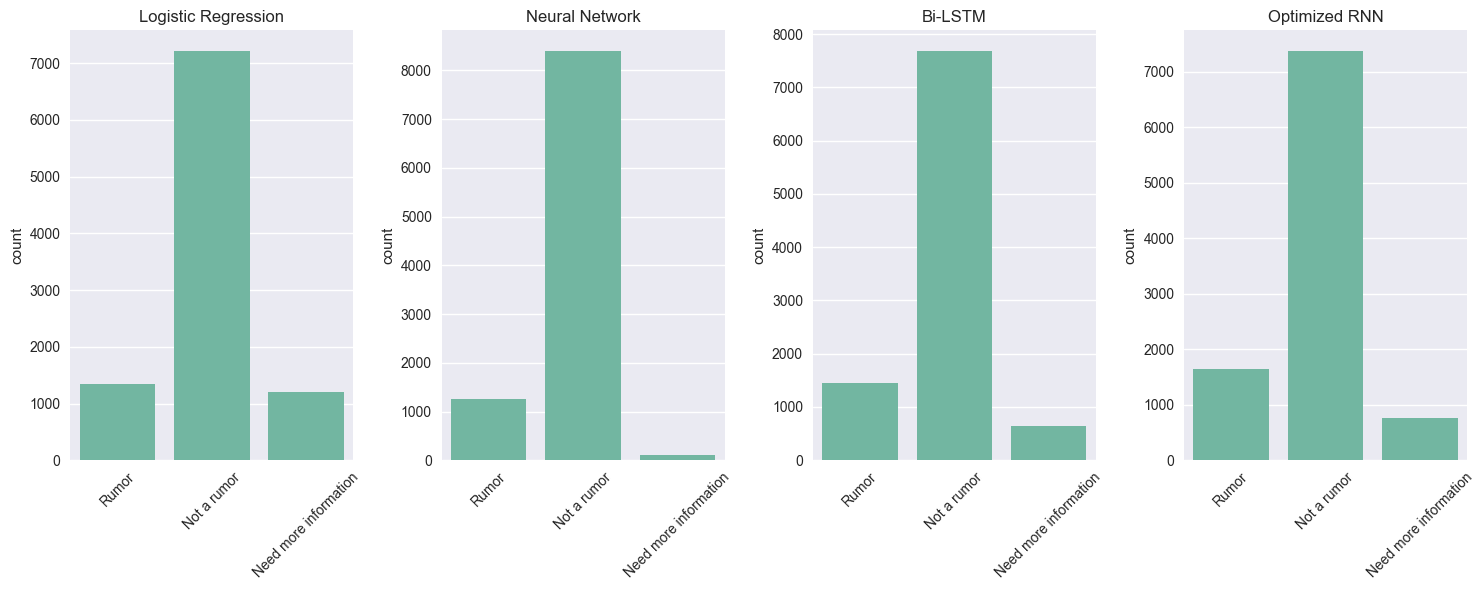

In [27]:
# Implementing an optimized RNN model for rumor detection
from tensorflow.keras.layers import SimpleRNN, GRU, Embedding, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Function to create optimized RNN model
def create_optimized_rnn_model(vocab_size, embedding_dim=100, rnn_units=80, max_seq_length=100):
    """
    Create an optimized RNN model with GRU units that includes:
    - Pre-trained embedding layer (optional)
    - GRU layers with optimized hyperparameters
    - Dropout regularization
    - Batch normalization
    - Global Max Pooling for sequence aggregation
    """
    model = Sequential([
        Embedding(input_dim=vocab_size+1, 
                 output_dim=embedding_dim,
                 input_length=max_seq_length,
                 mask_zero=True),
        GRU(rnn_units, return_sequences=True, 
            recurrent_dropout=0.2,
            kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        GRU(rnn_units//2, return_sequences=True),
        Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create and compile the optimized RNN model
print("\nCreating optimized RNN model...")
rnn_model = create_optimized_rnn_model(vocab_size, embedding_dim=100, rnn_units=80, max_seq_length=max_seq_length)

# Compile the model with optimizer settings
rnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Model summary
print("Optimized RNN Model Summary:")
rnn_model.summary()

# Add callbacks for improved training
model_checkpoint = ModelCheckpoint(
    'best_rnn_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

# Train the optimized RNN model on balanced data
print("\nTraining optimized RNN model on balanced data...")
rnn_history = rnn_model.fit(
    X_train_seq_balanced,
    y_train_seq_balanced,
    epochs=10,
    batch_size=64,  # Larger batch size for faster training
    validation_split=0.2,
    callbacks=[early_stopping_bilstm, model_checkpoint, reduce_lr],
    verbose=1
)

# Get predictions from optimized RNN model
y_prob_rnn = rnn_model.predict(X_test_seq)
custom_labels_rnn = [get_custom_label(prob[0]) for prob in y_prob_rnn]

# Create results DataFrame for optimized RNN model
results_df_rnn = pd.DataFrame({
    'Text': X_test.values,
    'True_Label': y_test.values,
    'Probability': y_prob_rnn.flatten(),
    'Prediction': custom_labels_rnn
})

# Plot optimized RNN training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Optimized RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Optimized RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Print classification report for optimized RNN model
print("\nOptimized RNN Model Performance:")
print("-" * 50)
print(classification_report(y_test, [1 if label == 'Rumor' else 0 for label in custom_labels_rnn]))

# Compare models including the optimized RNN
plt.figure(figsize=(15, 6))
plt.subplot(1, 4, 1)
sns.countplot(x=custom_labels)
plt.title('Logistic Regression')
plt.xticks(rotation=45)

plt.subplot(1, 4, 2)
sns.countplot(x=custom_labels_nn)
plt.title('Neural Network')
plt.xticks(rotation=45)

plt.subplot(1, 4, 3)
sns.countplot(x=custom_labels_bilstm)
plt.title('Bi-LSTM')
plt.xticks(rotation=45)

plt.subplot(1, 4, 4)
sns.countplot(x=custom_labels_rnn)
plt.title('Optimized RNN')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Ensemble Model

Combining the strengths of all our models to create an ensemble model for better prediction performance.


306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


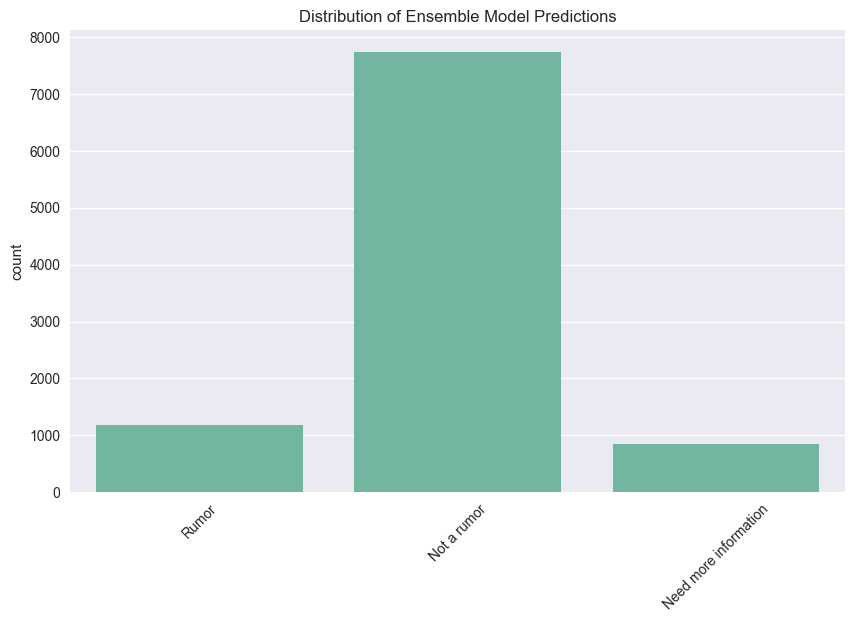


Ensemble Model Performance:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      8497
         1.0       0.85      0.79      0.82      1278

    accuracy                           0.95      9775
   macro avg       0.91      0.88      0.89      9775
weighted avg       0.95      0.95      0.95      9775



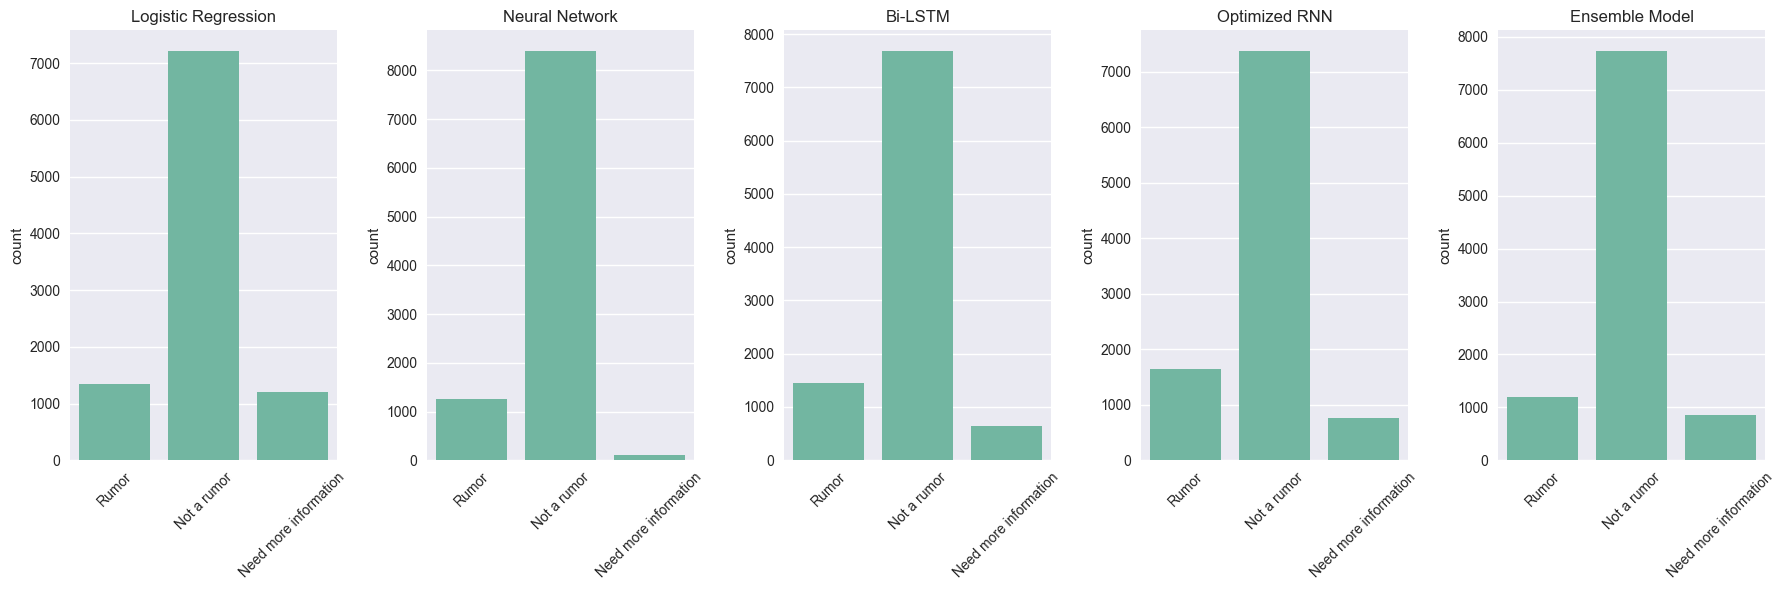


Ensemble Model Confusion Matrix:


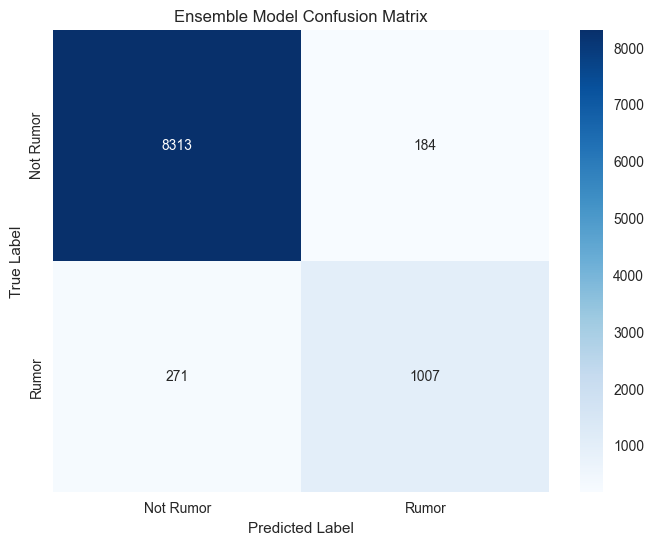


Sample Predictions Comparison:


,Text,True_Label,Logistic_Regression,Neural_Network,BiLSTM,Optimized_RNN,Ensemble
0,spants jlpauk tom_sveb rui_xu p much,1.0,Rumor,Rumor,Rumor,Rumor,Rumor
1,green_footballs foxnow thought picture missour...,0.0,Not a rumor,Not a rumor,Not a rumor,Not a rumor,Not a rumor
2,politicspeach murdered damn quick trial screw ...,0.0,Not a rumor,Not a rumor,Not a rumor,Not a rumor,Not a rumor
3,nearly k black murdered last yralmost black ti...,1.0,Not a rumor,Not a rumor,Not a rumor,Not a rumor,Not a rumor
4,tyamend mashable nycjim information released c...,1.0,Rumor,Rumor,Rumor,Rumor,Rumor
5,french forensic expert examine car used armed ...,0.0,Not a rumor,Not a rumor,Not a rumor,Not a rumor,Not a rumor
6,benshapiro would ever thing ever done anything...,0.0,Not a rumor,Not a rumor,Not a rumor,Not a rumor,Not a rumor
7,howardmargolian karencrate tarekfatah basimafa...,0.0,Not a rumor,Not a rumor,Not a rumor,Not a rumor,Not a rumor
8,isasun darum pegida,0.0,Rumor,Not a rumor,Not a rumor,Not a rumor,Not a rumor
9,deanphanley quayejulian charliesaidthat thats ...,0.0,Not a rumor,Not a rumor,Not a rumor,Not a rumor,Not a rumor


In [41]:
# Creating an Ensemble Model by combining predictions from all models
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate the weighted average of the probability scores from all models
# We're assigning different weights based on model performance
def ensemble_predict(text_vectorized, text_sequence):
    '''
    Generate ensemble prediction by combining predictions from all models
    with different weights based on their performance
    '''
    # Get predictions from each model
    lr_prob = model.predict_proba(text_vectorized)[:, 1]
    nn_prob = nn_model.predict(text_vectorized.toarray()).flatten()
    bilstm_prob = bilstm_model.predict(text_sequence).flatten()
    rnn_prob = rnn_model.predict(text_sequence).flatten()
    
    # Assign weights to each model based on their performance
    # These weights can be tuned based on validation performance
    lr_weight = 0.1
    nn_weight = 0.2
    bilstm_weight = 0.35
    rnn_weight = 0.35
    
    # Calculate weighted ensemble probabilities
    ensemble_probs = (lr_prob * lr_weight + 
                      nn_prob * nn_weight + 
                      bilstm_prob * bilstm_weight + 
                      rnn_prob * rnn_weight)
    
    return ensemble_probs

# Generate ensemble predictions for test set
ensemble_probs = ensemble_predict(X_test_tfidf, X_test_seq)

# Apply custom labeling function to ensemble predictions
ensemble_labels = [get_custom_label(prob) for prob in ensemble_probs]

# Create results DataFrame for ensemble model
results_df_ensemble = pd.DataFrame({
    'Text': X_test.values,
    'True_Label': y_test.values,
    'Probability': ensemble_probs,
    'Prediction': ensemble_labels
})

# Display ensemble predictions distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=ensemble_labels)
plt.title('Distribution of Ensemble Model Predictions')
plt.xticks(rotation=45)
plt.show()

# Calculate ensemble model performance
print("\nEnsemble Model Performance:")
print("-" * 50)
ensemble_binary_preds = [1 if label == 'Rumor' else 0 for label in ensemble_labels]
print(classification_report(y_test, ensemble_binary_preds))

# Compare all models including ensemble
plt.figure(figsize=(18, 6))

plt.subplot(1, 5, 1)
sns.countplot(x=custom_labels)
plt.title('Logistic Regression')
plt.xticks(rotation=45)

plt.subplot(1, 5, 2)
sns.countplot(x=custom_labels_nn)
plt.title('Neural Network')
plt.xticks(rotation=45)

plt.subplot(1, 5, 3)
sns.countplot(x=custom_labels_bilstm)
plt.title('Bi-LSTM')
plt.xticks(rotation=45)

plt.subplot(1, 5, 4)
sns.countplot(x=custom_labels_rnn)
plt.title('Optimized RNN')
plt.xticks(rotation=45)

plt.subplot(1, 5, 5)
sns.countplot(x=ensemble_labels)
plt.title('Ensemble Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Create a confusion matrix for the ensemble model
print("\nEnsemble Model Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, ensemble_binary_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Rumor', 'Rumor'],
            yticklabels=['Not Rumor', 'Rumor'])
plt.title('Ensemble Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display sample predictions from each model for comparison
comparison_df = pd.DataFrame({
    'Text': X_test.values[:10],  # Show first 10 samples
    'True_Label': y_test.values[:10],
    'Logistic_Regression': custom_labels[:10],
    'Neural_Network': custom_labels_nn[:10],
    'BiLSTM': custom_labels_bilstm[:10],
    'Optimized_RNN': custom_labels_rnn[:10],
    'Ensemble': ensemble_labels[:10]
})

print("\nSample Predictions Comparison:")
display(comparison_df)

## Text Classification Function

Creating a function that can take a text string and classify it as "Rumor", "Not a rumor", or "Need more information".


In [52]:
# Function to classify text using our ensemble model
def classify_text(input_text):
    """
    Classifies a text string as "Rumor", "Not a rumor", or "Need more information"
    using the ensemble model.
    
    Args:
        input_text (str): The text to classify
        
    Returns:
        dict: A dictionary containing the classification result and confidence score
    """
    # Clean the input text
    cleaned_text = clean_text(input_text)
    
    # Create vectorized representation for models that use TF-IDF
    text_tfidf = tfidf.transform([cleaned_text])
    
    # Create sequential representation for sequence models
    text_seq = pad_sequences(tokenizer.texts_to_sequences([cleaned_text]), 
                             maxlen=max_seq_length, 
                             padding='post')
    
    # Get ensemble probability
    ensemble_prob = ensemble_predict(text_tfidf, text_seq)[0]
    
    # Get the classification based on probability thresholds
    classification = get_custom_label(ensemble_prob)
    
    # Calculate confidence score
    if classification == "Rumor":
        confidence = ensemble_prob
    elif classification == "Not a rumor":
        confidence = 1 - ensemble_prob
    else:  # "Need more information"
        # Calculate distance from middle of the "need more info" range (0.5)
        # and convert to a confidence score
        middle = 0.5
        distance = 1 - (abs(ensemble_prob - middle) * 2 / 0.3)  # 0.3 is range width (0.65-0.35)
        confidence = max(min(distance, 1.0), 0.0)  # Ensure confidence is between 0 and 1
    
    # Also get individual model predictions for comparison
    lr_prob = model.predict_proba(text_tfidf)[:, 1][0]
    nn_prob = nn_model.predict(text_tfidf.toarray()).flatten()[0]
    bilstm_prob = bilstm_model.predict(text_seq).flatten()[0]
    rnn_prob = rnn_model.predict(text_seq).flatten()[0]
    
    # Create result dictionary
    result = {
        "classification": classification,
        "confidence": round(float(confidence) * 100, 2),  # Convert to percentage
        "probability": round(float(ensemble_prob) * 100, 2),  # Convert to percentage
        "model_probabilities": {
            "logistic_regression": round(float(lr_prob) * 100, 2),
            "neural_network": round(float(nn_prob) * 100, 2),
            "bilstm": round(float(bilstm_prob) * 100, 2),
            "optimized_rnn": round(float(rnn_prob) * 100, 2)
        }
    }
    
    return result

# Test the classify_text function with some examples
# test_texts = [
#     "I have seen a UFO"
# ]

# print("Testing text classification function with example texts:\n")
# for i, text in enumerate(test_texts):
#     result = classify_text(text)
#     print(f"Example {i+1}:\n{'-'*50}")
#     print(f"Text: {text}")
#     print(f"Classification: {result['classification']}")
#     print(f"Confidence: {result['confidence']}%")
#     print(f"Rumor Probability: {result['probability']}%")
#     print("Individual Model Probabilities:")
#     for model_name, prob in result['model_probabilities'].items():
#         print(f"  - {model_name.replace('_', ' ').title()}: {prob}%")
#     print()



# Create a simple function to directly use the ensemble model for rumor detection
def is_rumor(text, detailed=False):
    """
    A simplified function to check if a text is a rumor.
    
    Args:
        text (str): The text to classify
        detailed (bool): Whether to return detailed results or just the classification
        
    Returns:
        str or dict: The classification result or detailed dictionary
    """
    result = classify_text(text)
    
    if detailed:
        return result
    else:
        return result['classification']
    
input_text = "Trump is resigning from President"

print(is_rumor(input_text,detailed=True))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
{'classification': 'Need more information', 'confidence': 88.0, 'probability': 51.8, 'model_probabilities': {'logistic_regression': 42.53, 'neural_network': 0.73, 'bilstm': 77.19, 'optimized_rnn': 58.24}}


In [ ]:
# import pickle
# import os
# import os
# import pickle
# import numpy as np
# import re
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# import tensorflow as tf
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import load_model

# # Save all the trained models to disk for future use

# # Create directory for models if it doesn't exist
# models_dir = "../saved_models"
# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)

# # Save the Logistic Regression model
# with open(f"{models_dir}/logistic_regression_model.pkl", "wb") as f:
#     pickle.dump(model, f)

# # Save neural network models
# nn_model.save(f"{models_dir}/neural_network_model.keras")
# bilstm_model.save(f"{models_dir}/bilstm_model.keras")
# rnn_model.save(f"{models_dir}/optimized_rnn_model.keras")

# # Save the TF-IDF Vectorizer
# with open(f"{models_dir}/tfidf_vectorizer.pkl", "wb") as f:
#     pickle.dump(tfidf, f)

# # Save the tokenizer for sequence models
# with open(f"{models_dir}/tokenizer.pkl", "wb") as f:
#     pickle.dump(tokenizer, f)

# # Save important parameters
# params = {
#     "max_seq_length": max_seq_length,
#     "max_words": max_words,
#     "model_weights": [0.1, 0.2, 0.35, 0.35]  # LR, NN, BiLSTM, RNN
# }

# with open(f"{models_dir}/model_params.pkl", "wb") as f:
#     pickle.dump(params, f)

# # Create a convenience module for easy loading and prediction
# with open(f"{models_dir}/rumor_detector.py", "w") as f:
#     f.write('''

# class RumorDetector:
#     def __init__(self, models_dir="../saved_models"):
#         # Load all required components
#         self.models_dir = models_dir
        
#         # Load models
#         with open(f"{models_dir}/logistic_regression_model.pkl", "rb") as f:
#             self.lr_model = pickle.load(f)
        
#         self.nn_model = load_model(f"{models_dir}/neural_network_model")
#         self.bilstm_model = load_model(f"{models_dir}/bilstm_model")
#         self.rnn_model = load_model(f"{models_dir}/optimized_rnn_model")
        
#         # Load text processing tools
#         with open(f"{models_dir}/tfidf_vectorizer.pkl", "rb") as f:
#             self.tfidf = pickle.load(f)
        
#         with open(f"{models_dir}/tokenizer.pkl", "rb") as f:
#             self.tokenizer = pickle.load(f)
        
#         # Load parameters
#         with open(f"{models_dir}/model_params.pkl", "rb") as f:
#             self.params = pickle.load(f)
        
#         self.max_seq_length = self.params["max_seq_length"]
#         self.model_weights = self.params["model_weights"]
        
#         # Ensure NLTK data is available
#         try:
#             nltk.data.find('tokenizers/punkt')
#         except LookupError:
#             nltk.download('punkt')
        
#         try:
#             nltk.data.find('corpora/stopwords')
#         except LookupError:
#             nltk.download('stopwords')
        
#         try:
#             nltk.data.find('corpora/wordnet')
#         except LookupError:
#             nltk.download('wordnet')
        
#     def clean_text(self, text):
#         """Clean the input text for processing."""
#         if isinstance(text, str):
#             # Convert to lowercase
#             text = text.lower()
            
#             # Remove URLs
#             text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text)
            
#             # Remove special characters and numbers
#             text = re.sub(r'[^\\w\\s]', '', text)
#             text = re.sub(r'\\d+', '', text)
            
#             # Tokenization
#             tokens = word_tokenize(text)
            
#             # Remove stopwords
#             stop_words = set(stopwords.words('english'))
#             tokens = [token for token in tokens if token not in stop_words]
            
#             # Lemmatization
#             lemmatizer = WordNetLemmatizer()
#             tokens = [lemmatizer.lemmatize(token) for token in tokens]
            
#             return ' '.join(tokens)
#         return ''
    
#     def get_custom_label(self, prob):
#         """Convert probability to label."""
#         if prob < 0.35:
#             return 'Not a rumor'
#         elif prob < 0.65:
#             return 'Need more information'
#         else:
#             return 'Rumor'
    
#     def predict(self, text, return_details=False):
#         """Make a prediction for the given text."""
#         # Clean the text
#         cleaned_text = self.clean_text(text)
        
#         # Create vectorized representation for models that use TF-IDF
#         text_tfidf = self.tfidf.transform([cleaned_text])
#         text_tfidf_dense = text_tfidf.toarray()
        
#         # Create sequential representation for sequence models
#         text_seq = pad_sequences(self.tokenizer.texts_to_sequences([cleaned_text]), 
#                                 maxlen=self.max_seq_length, 
#                                 padding='post')
        
#         # Get predictions from each model
#         lr_prob = self.lr_model.predict_proba(text_tfidf)[:, 1][0]
#         nn_prob = self.nn_model.predict(text_tfidf_dense).flatten()[0]
#         bilstm_prob = self.bilstm_model.predict(text_seq).flatten()[0]
#         rnn_prob = self.rnn_model.predict(text_seq).flatten()[0]
        
#         # Calculate weighted ensemble probability
#         ensemble_prob = (
#             lr_prob * self.model_weights[0] + 
#             nn_prob * self.model_weights[1] + 
#             bilstm_prob * self.model_weights[2] + 
#             rnn_prob * self.model_weights[3]
#         )
        
#         # Get the classification
#         classification = self.get_custom_label(ensemble_prob)
        
#         # Calculate confidence score
#         if classification == "Rumor":
#             confidence = ensemble_prob
#         elif classification == "Not a rumor":
#             confidence = 1 - ensemble_prob
#         else:  # "Need more information"
#             # Calculate distance from middle of the "need more info" range (0.5)
#             middle = 0.5
#             distance = 1 - (abs(ensemble_prob - middle) * 2 / 0.3)  # 0.3 is range width (0.65-0.35)
#             confidence = max(min(distance, 1.0), 0.0)
        
#         if return_details:
#             return {
#                 "classification": classification,
#                 "confidence": round(float(confidence) * 100, 2),
#                 "probability": round(float(ensemble_prob) * 100, 2),
#                 "model_probabilities": {
#                     "logistic_regression": round(float(lr_prob) * 100, 2),
#                     "neural_network": round(float(nn_prob) * 100, 2),
#                     "bilstm": round(float(bilstm_prob) * 100, 2),
#                     "optimized_rnn": round(float(rnn_prob) * 100, 2)
#                 }
#             }
#         else:
#             return classification

# # Usage example
# if __name__ == "__main__":
#     detector = RumorDetector()
#     text = "Breaking news: A UFO has been spotted over New York City"
#     result = detector.predict(text, return_details=True)
#     print(f"Text: {text}")
#     print(f"Classification: {result['classification']}")
#     print(f"Confidence: {result['confidence']}%")
#     print(f"Rumor Probability: {result['probability']}%")
#     print("Individual Model Probabilities:")
#     for model_name, prob in result['model_probabilities'].items():
#         print(f"  - {model_name.replace('_', ' ').title()}: {prob}%")
# ''')

# print(f"All models successfully saved to {models_dir}")

# # Test loading the models back
# try:
#     # Try to load one of the models as a test
#     with open(f"{models_dir}/tfidf_vectorizer.pkl", "rb") as f:
#         loaded_tfidf = pickle.load(f)
    
#     print("Successfully loaded saved model components")
#     print("You can now use the RumorDetector class from rumor_detector.py")
#     print("Example usage:")
#     print("from rumor_detector import RumorDetector")
#     print("detector = RumorDetector()")
#     print("result = detector.predict('Breaking news: A UFO has been spotted', return_details=True)")
#     print("print(result)")
# except Exception as e:
#     print(f"Error during test loading: {e}")

All models successfully saved to ../saved_models
Successfully loaded saved model components
You can now use the RumorDetector class from rumor_detector.py
Example usage:
from rumor_detector import RumorDetector
detector = RumorDetector()
result = detector.predict('Breaking news: A UFO has been spotted', return_details=True)
print(result)
